In [1]:
import json
import pickle
import bz2
import regex
from tqdm import tqdm
from scipy import sparse
import warnings
warnings.filterwarnings('ignore')
from sklearn.semi_supervised import LabelSpreading
from sklearn.semi_supervised import LabelPropagation

In [2]:
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%pylab inline
from nltk.corpus import stopwords
from pymystem3 import Mystem
from gensim.models import Word2Vec
from sklearn.manifold import TSNE
from pymorphy2 import MorphAnalyzer

Populating the interactive namespace from numpy and matplotlib


In [3]:
responses = []
with bz2.BZ2File('banki_responses.json.bz2', 'r') as thefile:
    for row in tqdm(thefile):
        resp = json.loads(row)
        if not resp['rating_not_checked'] and (len(resp['text'].split()) > 0):
            responses.append(resp)

201030it [01:06, 3039.84it/s]



#  Домашнее задание по NLP # 2 [100 баллов] 
## Составление словарей для классификации по тональности
При классификации текстов или предложений по тональности необходимо использовать оценочные словари для предметной области, то есть, такие словари, в которых содержатся отрицательные и позитивные слова для какой-то предметной области. Идея подобных словарей основана на следующих наблюдениях: во-первых, для разных товаров используются разные оценочные слова (например бывает “захватывающая книга”, но не бывает “захватывающих лыж”), во-вторых, в контексте разных товаров одни и те же слова могут иметь разную окраску (слово “тормоз” в отзыве на велосипед имеет нейтральную окраску, в отзыве на компьютер – резко негативную, “пыль” в контексте пылесосов – нейтральную, в контексте кофемолок – положительную (“мелкий помол в пыль”)). Еще один пример: "теплое пиво" – это плохо, а "теплый свитер" – это хорошо.  

Составление таких словарей в ручную – трудоемкий процесс, но, к счастью, его не сложно автоматизировать, если собрать достаточно большие корпуса отзывов. В этом домашнем задании вам предстоит попробовать реализовать один их подходов к составлению оценочных словарей, основанный на статье Inducing Domain-Specific Sentiment Lexicons from Unlabeled Corpora (https://nlp.stanford.edu/pubs/hamilton2016inducing.pdf).


Данные для задания – уже знакомые вам отзывы на банки, собранные с нескольких сайтов Рунета. Отзывы могут быть как положительными (оценка 5), так и отрицательными (оценка 1).

In [4]:
responses[99]

{'city': 'г. Саратов',
 'rating_not_checked': False,
 'title': 'Карта ко вкладу',
 'num_comments': 0,
 'bank_license': 'лицензия № 880',
 'author': 'ronnichka',
 'bank_name': 'Югра',
 'datetime': '2015-06-03 20:56:57',
 'text': 'Здравствуйте! Хотела написать, что мне месяц не выдают карту ко вкладу, ссылаясь на "нам же их из Самары везут" (на секундочку 5 часов езды от нашего города). Но! Прочитала, что людям 3,5 месяцев не выдают карту, и поняла, что у меня все хорошо, пока что. И подарок мне дали, и кулер в отделении есть. Так что я, конечно, готова ждать. Правда хотелось бы не очень долго.',
 'rating_grade': 3}

## Часть 1. Обучение модели word2vec [50 баллов]

1. Разбейте всю коллекцию отзывов на предложения. Лемматизируйте все слова. 
2. Обучите по коллекции предложений word2vec
3. Приведите несколько удачных и неудачных примеров решения стандартных текстов для word2vec:
    * тест на определение ближайших слов
    * тест на аналогии (мужчина – король : женщина – королева)
    * тест на определение лишнего слова.
    
4. Постройте несколько визуализаций:
    * TSNE для топ-100 (или топ-500) слов и найдите осмысленные кластеры слов
    * задайте координаты для нового пространства следующим образом: одна  ось описывает отношение "плохо – хорошо", вторая – "медленно – быстро" и найдите координаты названий банков в этих координатах.  Более формально:
    берем вектор слова "хорошо", вычитаем из него вектор слова "плохо", получаем новый вектор, который описывает разницу между хорошими и плохими словами. Берем вектор слова "сбербанк" и умножаем его на этот новый вектор – получаем координату по первой оси. Аналогично – для второй оси. Две координаты уже можно нарисовать на плоскости.  
 


Ссылка на примеры визуализаций: https://towardsdatascience.com/game-of-thrones-word-embeddings-does-r-l-j-part-2-30290b1c0b4b

In [ ]:
df=pd.DataFrame.from_dict(responses)

In [7]:
df.to_pickle('df.zip')

In [70]:
df = pd.read_pickle('df.zip')

In [71]:
df.head(2)

,author,bank_license,bank_name,city,datetime,num_comments,rating_grade,rating_not_checked,text,title
0,uhnov1,лицензия № 2562,Бинбанк,г. Москва,2015-06-08 12:50:54,0,NaN,False,Добрый день! Я не являюсь клиентом банка и пор...,Жалоба
1,Foryou,лицензия № 1481,Сбербанк России,г. Новосибирск,2015-06-08 11:09:57,0,NaN,False,Доброго дня! Являюсь держателем зарплатной кар...,Не могу пользоваться услугой Сбербанк он-лайн


### 1.1 Разбейте всю коллекцию отзывов на предложения. Лемматизируйте все слова.

In [7]:
import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize

sentenses = []

for text in tqdm(df.text):
    
    for sent in sent_tokenize(text):
        sentenses.append(sent)
        
print(len(sentenses))
print(sentenses[:2])

[nltk_data] Downloading package punkt to /home/gavril/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
100%|██████████| 153499/153499 [01:33<00:00, 1648.97it/s]

2664456
['Добрый день!', 'Я не являюсь клиентом банка и поручителем по кредитному договору, а также не являюсь каким-либо другим лицом, письменно  оформившим отношения с банком по поводу урегулирования чьей-либо  задолженности.']


In [25]:
sentenses[0]

'Добрый день!'

In [ ]:
with open('sentenses', 'wb') as fp:
    pickle.dump(sentenses, fp)

In [6]:
with open('sentenses_lemma', 'rb') as f:
    sentenses = pickle.load(f)

In [79]:
regex = re.compile("[А-Яа-я]+")
def words_only(text, regex=regex):
    return " ".join(regex.findall(text))


mystopwords = stopwords.words('russian') + ['это', 'наш' , 'тыс', 'млн', 'млрд', 'также',  'т', 'д','вы']
def  remove_stopwords(text, mystopwords = mystopwords):
    try:
        return " ".join([token for token in text.split() if not token in mystopwords])
    except:
        return ""

    
m = Mystem()
def lemmatize(text, mystem=m):
    try:
        return "".join(m.lemmatize(text)).strip()  
    except:
        return " "
    
def preprocessing(text):
    words = words_only(text)
    no_stopwords = remove_stopwords(words)
    lemmas = lemmatize(no_stopwords)
    return(lemmas)

In [12]:
preprocessing(sentenses[1])


'являться клиент банк поручитель кредитный договор являться либо лицо письменно оформлять отношение банк повод урегулирование чей либо задолженность'

In [13]:
sentenses_lemma=[]
for sent in tqdm(sentenses[:]):
    #print(sent)
    sentenses_lemma.append(preprocessing(sent).split())

100%|██████████| 2664456/2664456 [11:10<00:00, 3974.10it/s]


In [15]:
sentenses_lemma[:2]

[['добрый', 'день'],
 ['являться',
  'клиент',
  'банк',
  'поручитель',
  'кредитный',
  'договор',
  'являться',
  'либо',
  'лицо',
  'письменно',
  'оформлять',
  'отношение',
  'банк',
  'повод',
  'урегулирование',
  'чей',
  'либо',
  'задолженность']]

In [19]:
len(sentense)

2664456

In [16]:
with open('sentenses_lemma', 'wb') as fp:
    pickle.dump(sentenses_lemma, fp)

In [59]:
with open('sentenses_lemma', 'rb') as f:
    sentenses_lemma = pickle.load(f)

In [60]:
len(sentenses_lemma)

2664456

### 1.2 Обучите по коллекции предложений word2vec

In [28]:
%time model_banks_size_100_win_3 = Word2Vec(sentenses_lemma, size=100, window=3, min_count=5, workers=12,sg=True)

CPU times: user 9min 41s, sys: 53.8 ms, total: 9min 41s
Wall time: 1min 15s


### 1.2 Приведите несколько удачных и неудачных примеров решения стандартных текстов для word2vec:
    * тест на определение ближайших слов
    * тест на аналогии (мужчина – король : женщина – королева)
    * тест на определение лишнего слова.

 * тест на определение ближайших слов

In [53]:
model_banks_size_100_win_3.wv.most_similar('банк')

[('банка', 0.7386811971664429),
 ('БМ', 0.7169050574302673),
 ('росбанк', 0.6964902877807617),
 ('промсвязьбанк', 0.6916427612304688),
 ('БРС', 0.6913061141967773),
 ('ситибанк', 0.6840859651565552),
 ('сбер', 0.6831763982772827),
 ('райффазенбанк', 0.6829168796539307),
 ('юкб', 0.6681942343711853),
 ('ПСБ', 0.6667803525924683)]

In [54]:
model_banks_size_100_win_3.most_similar('кредит')

[('автокредит', 0.8683719635009766),
 ('потребкредит', 0.8343874216079712),
 ('потреба', 0.7961019277572632),
 ('автокред', 0.7739664316177368),
 ('потребительский', 0.7656630873680115),
 ('ипотека', 0.7496848702430725),
 ('ссуда', 0.7356037497520447),
 ('быстрокредит', 0.7212080955505371),
 ('нецелевой', 0.7065843343734741),
 ('рассрочка', 0.6705203652381897)]

In [55]:
model_banks_size_100_win_3.most_similar('банкомат')

[('терминал', 0.8106145858764648),
 ('бакомат', 0.8089646100997925),
 ('атма', 0.7972457408905029),
 ('банкомет', 0.7818796634674072),
 ('банкамат', 0.7338375449180603),
 ('банокмат', 0.7025562524795532),
 ('кэшино', 0.7012708187103271),
 ('депозитор', 0.6932367086410522),
 ('аппарат', 0.6807467341423035),
 ('устройство', 0.6797964572906494)]

#### Попробуем поиграться с парметрами

In [32]:
model_banks_size_300_win_5 = Word2Vec(sentenses_lemma, size=300, window=5, min_count=20, workers=12,sg=True)

In [266]:
model_banks_size_300_win_5.save("model_banks_size_300_win_5.model")

In [3]:

model_banks_size_300_win_5= Word2Vec.load("model_banks_size_300_win_5.model")

In [33]:
sentenses_lemma[0]

['добрый', 'день']

In [268]:
model_banks_size_300_win_5.most_similar('банк')

[('пробизнес', 0.5226661562919617),
 ('транскапиталбанк', 0.5216688513755798),
 ('евротраст', 0.5092047452926636),
 ('райффазенбанк', 0.5086787939071655),
 ('челиндбанк', 0.5074278712272644),
 ('газэнергобанк', 0.5061803460121155),
 ('росбанк', 0.5020236968994141),
 ('экстробанк', 0.5015712976455688),
 ('промсвязьбанк', 0.4956953227519989),
 ('сбер', 0.49378693103790283)]

In [57]:
model_banks_size_300_win_5.most_similar('кредит')

[('автокредит', 0.7075753211975098),
 ('потребкредит', 0.6529462337493896),
 ('потребительский', 0.6416990756988525),
 ('потреба', 0.6370478868484497),
 ('автокред', 0.6233214139938354),
 ('ссуда', 0.6032420992851257),
 ('ипотека', 0.5994747281074524),
 ('евроремонт', 0.5911850929260254),
 ('перекредитация', 0.569797158241272),
 ('нецелевой', 0.5519369840621948)]

In [58]:
model_banks_size_300_win_5.most_similar('очередь')

[('толпа', 0.6152852773666382),
 ('давка', 0.6064802408218384),
 ('толпиться', 0.5998757481575012),
 ('толкотня', 0.5943339467048645),
 ('столпотворение', 0.5925817489624023),
 ('километровый', 0.5905577540397644),
 ('томиться', 0.5782584547996521),
 ('битком', 0.5767631530761719),
 ('высиживать', 0.5751825571060181),
 ('очередник', 0.5666207075119019)]

In [261]:
# Гм, ну в целом похоже на правду

  * тест на аналогии (мужчина – король : женщина – королева)

In [260]:
model_banks_size_300_win_5.most_similar(positive=['рубль',"доллар"], negative=["российский"])

[('евро', 0.6529797911643982),
 ('руб', 0.601260244846344),
 ('евроцент', 0.5789920091629028),
 ('долл', 0.5780405402183533),
 ('бакс', 0.5686252117156982),
 ('тысяча', 0.5563974976539612),
 ('уе', 0.550661563873291),
 ('дол', 0.5479140281677246),
 ('еврик', 0.5475706458091736),
 ('р', 0.5234415531158447)]

In [ ]:
# Тут не очень похоже

 * тест на определение лишнего слова.

In [51]:
model_banks_size_300_win_5.doesnt_match("деньги доллар собака".split())

'собака'

In [60]:
model_banks_size_300_win_5.doesnt_match("автокредит ипотека потребительский вклад".split())

'вклад'

In [62]:
model_banks_size_300_win_5.doesnt_match('кабинет комната офис банкомат'.split())

'банкомат'

In [ ]:
# Вроде справляется

### 1.4  Постройте несколько визуализаций:
    * TSNE для топ-100 (или топ-500) слов и найдите осмысленные кластеры слов
    * задайте координаты для нового пространства следующим образом: одна  ось описывает отношение "плохо –  хорошо", вторая – "медленно – быстро" и найдите координаты названий банков в этих координатах. 
    Более формально:
    берем вектор слова "хорошо", вычитаем из него вектор слова "плохо", получаем новый вектор, который описывает разницу между хорошими и плохими словами. Берем вектор слова "сбербанк" и умножаем его на этот новый вектор – получаем координату по первой оси. Аналогично – для второй оси. Две координаты уже можно нарисовать на плоскости.  
 


Ссылка на примеры визуализаций: https://towardsdatascience.com/game-of-thrones-word-embeddings-does-r-l-j-part-2-30290b1c0b4b

* TSNE для топ-100 (или топ-500) слов и найдите осмысленные кластеры слов

In [61]:
top_words = []
from nltk import FreqDist
fd = FreqDist()
for text in sentenses_lemma:
    fd.update(text)
for i in fd.most_common(500):
    top_words.append(i[0])
print(top_words[:15])

['банк', 'карта', 'деньги', 'день', 'кредит', 'который', 'отделение', 'клиент', 'сотрудник', 'счет', 'сказать', 'сумма', 'получать', 'заявление', 'год']


In [62]:
len(top_words)

500

In [63]:
top_words = [w for w in top_words if len(w) > 4]
len(top_words)

433

In [64]:
top_words_vec = model_banks_size_300_win_5[top_words]

In [65]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=0)
top_words_tsne = tsne.fit_transform(top_words_vec)

In [66]:
from bokeh.models import ColumnDataSource, LabelSet
from bokeh.plotting import figure, show, output_file
from bokeh.io import output_notebook
output_notebook()

p = figure(tools="pan,wheel_zoom,reset,save",
           toolbar_location="above",
           title="word2vec T-SNE for most common words")

source = ColumnDataSource(data=dict(x1=top_words_tsne[:,0],
                                    x2=top_words_tsne[:,1],
                                    names=top_words))

p.scatter(x="x1", y="x2", size=8, source=source)

labels = LabelSet(x="x1", y="x2", text="names", y_offset=6,
                  text_font_size="6pt", text_color="#555555",
                  source=source, text_align='center')
p.add_layout(labels)

show(p)

Loading BokehJS ...

#### Можно выделить множетсво остмысленных кластеров:
* страхование-тариф -услуга
* банкомат-средства-наличные-деньги
* номер-телефон-трубка-оператор
* запрос-обращение-претензия

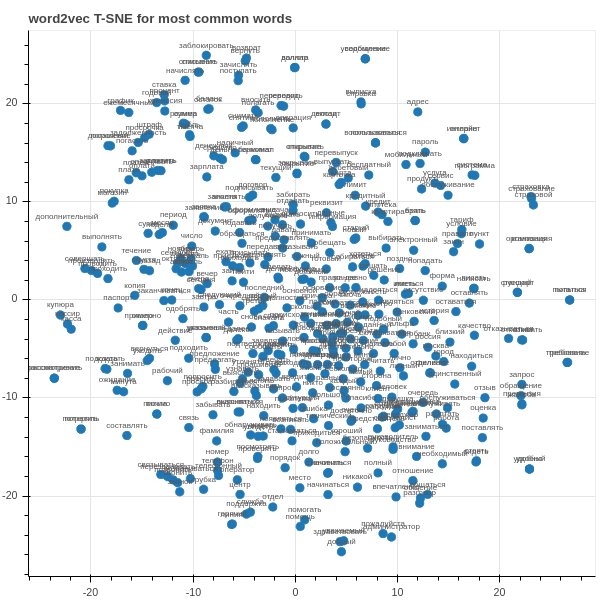

In [266]:
# В гите карртинка не отбражается, сохранил её
from IPython.display import Image
Image("bokeh_plot.png")

* задайте координаты для нового пространства следующим образом: одна  ось описывает отношение "плохо –  хорошо", вторая – "медленно – быстро" и найдите координаты названий банков в этих координатах. 
 Более формально:
 берем вектор слова "хорошо", вычитаем из него вектор слова "плохо", получаем новый вектор, который описывает   разницу между хорошими и плохими словами. Берем вектор слова "сбербанк" и умножаем его на этот новый вектор   – получаем координату по первой оси. Аналогично – для второй оси. Две координаты уже можно нарисовать на  плоскости.

In [72]:
xorosh_minus_plox=model_banks_size_300_win_5['хороший']-model_banks_size_300_win_5['плохо']

In [73]:
bistr_minus_medlen=model_banks_size_300_win_5['быстро']-model_banks_size_300_win_5['медленно']

In [74]:
df.head(3)

,author,bank_license,bank_name,city,datetime,num_comments,rating_grade,rating_not_checked,text,title
0,uhnov1,лицензия № 2562,Бинбанк,г. Москва,2015-06-08 12:50:54,0,NaN,False,Добрый день! Я не являюсь клиентом банка и пор...,Жалоба
1,Foryou,лицензия № 1481,Сбербанк России,г. Новосибирск,2015-06-08 11:09:57,0,NaN,False,Доброго дня! Являюсь держателем зарплатной кар...,Не могу пользоваться услугой Сбербанк он-лайн
2,Vladimir84,лицензия № 2562,Бинбанк,г. Москва,2015-06-05 20:14:28,1,NaN,False,Здравствуйте! Дублирую свое заявление от 03.0...,Двойное списание за один товар.


In [250]:
#  У нас в отзывах доминирует сбер, что ожидаемо
df.bank_name.value_counts(normalize=1).head(25)

Сбербанк России                   0.171513
Альфа-Банк                        0.066606
ВТБ 24                            0.053323
Русский Стандарт                  0.051746
Хоум Кредит Банк                  0.049179
Тинькофф Банк                     0.035095
Национальный Банк «Траст»         0.030013
Ренессанс Кредит                  0.025075
Связной Банк                      0.024593
ОТП Банк                          0.021088
Восточный Экспресс Банк           0.020443
Райффайзенбанк                    0.019915
Московский Кредитный Банк         0.019179
Ситибанк                          0.018554
Авангард                          0.017805
Промсвязьбанк                     0.016847
ЮниКредит Банк                    0.016209
Банк Москвы                       0.016000
Ханты-Мансийский банк Открытие    0.014059
МТС Банк                          0.012182
Киви Банк                         0.011342
Кредит Европа Банк                0.010964
Росбанк                           0.010801
Бинбанк    

In [76]:
# Возьмем первые 25, чтобы каши не было
bank_name=df.bank_name.value_counts(normalize=1).index.tolist()[:25]

In [80]:
bank_name=[preprocessing(bank.lower()).split()[0] for bank in bank_name ]
bank_name

['сбербанк',
 'альфа',
 'втб',
 'русский',
 'хоум',
 'тинькофф',
 'национальный',
 'ренессанс',
 'связной',
 'отп',
 'восточный',
 'райффайзенбанк',
 'московский',
 'ситибанк',
 'авангард',
 'промсвязьбанк',
 'юникредит',
 'банк',
 'ханты',
 'мтс',
 'киви',
 'кредит',
 'росбанк',
 'бинбанк',
 'бинбанк']

In [252]:
df_temp=pd.DataFrame(bank_name,columns=['bank_name'])

In [253]:
df_temp['kachestvo']=df_temp.apply(lambda  row:np.dot(model_banks_size_300_win_5[row['bank_name']],xorosh_minus_plox) ,axis=1)

In [254]:
df_temp['skorost']=df_temp.apply(lambda  row:np.dot(model_banks_size_300_win_5[row['bank_name']],bistr_minus_medlen) ,axis=1)

In [257]:
df_temp.head()

,bank_name,kachestvo,skorost
0,сбербанк,0.959767,-0.147402
1,альфа,0.946438,0.284290
2,втб,0.662389,0.367923
3,русский,0.103523,0.010437
4,хоум,1.627054,0.950497


In [256]:
output_notebook()

p = figure(tools="pan,wheel_zoom,reset,save",
           toolbar_location="above",
           title="word2vec T-SNE for most common words")

source = ColumnDataSource(data=dict(x1=df_temp.kachestvo,
                                    x2=df_temp.skorost,
                                    names=df_temp.bank_name))

p.scatter(x="x1", y="x2", size=8, source=source)

labels = LabelSet(x="x1", y="x2", text="names", y_offset=6,
                  text_font_size="9pt", text_color="#555555",
                  source=source, text_align='center')
p.add_layout(labels)
p.xaxis.axis_label = 'Качество'
p.yaxis.axis_label = 'Скорость'
show(p)

Loading BokehJS ...

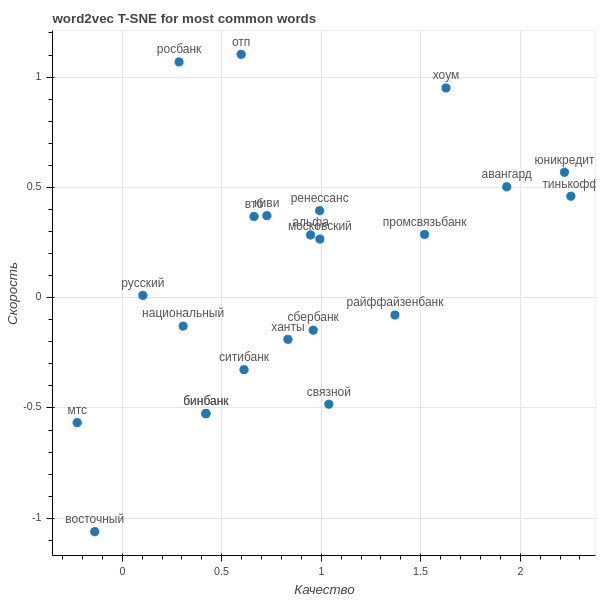

In [265]:
# В гите карртинка не отбражается, сохранил её
from IPython.display import Image
Image("bokeh_plot_1.png")

#### Интересная картика, самый медленный и ужасный - Вострочный, где-то посередине-Сбер,самые качественные -юникретит и тинькофф

## Часть 2. Распространение метки [50 баллов]

Определите 5-8 позитивных слов (например, “быстрый”, “удобный”) и 5-8  негативных слов (например,“очередь”, “медленно”). Эти слова будут основной будущего оценочного словаря. Пусть позитивному классу соответствует метка 1, негативному – -1. Пометьте выбранные слова в лексическом графе соответствующими метками. Запустите любой известный вам метод распространения метки (Label Propogation) в лексическом графе. На выходе метода распространения ошибки должны быть новые слова, помеченные метками 1 и -1 – это и есть искомые оценочные слова.

Алгоритмы распространения метки устроены примерно так: пусть мы находимся в выршине, помеченном +1. С какой-то вероятностью мы переносим эту метку на соседние узлы. С меньшей вероятностью переносим ее на вершины на расстоянии два. В конце распространения метки, часть вершин оказывается помечена меткой +1, часть – -1, большая часть остается без метки.

Рекомендуемые алгоритмы распространения метки:
1. ```graphlab.label_propagation``` (```graphlab``` доступен бесплатно по образовательной лицензии)
2. ```sklearn.semi_supervised.LabelPropagation``` 
3. ```sklearn.semi_supervised.LabelSpreading```

In [5]:
positive=['быстрый','удобный','качественный','хороший','красивый' ,'приятный']
negative=[  'медленный','долгий','плохой','очередь','ждать' ,'ужасный']

In [244]:
X=positive+negative


In [245]:
y=[1 if x in positive  else 0  if x in negative else -1 for x in words]
y=np.array(y)
y

array([-1, -1, -1, ..., -1, -1, -1])

In [96]:
np.unique(y, return_counts=True)

(array([-1,  1,  2]), array([17165,     6,     6]))

In [115]:
# Заберем вектора слов
X=model_banks_size_300_win_5[model_banks_size_300_win_5.wv.vocab.keys()]

In [187]:
# И сами слов 
words=model_banks_size_300_win_5.wv.vocab.keys()

In [ ]:
# Пусть позитивиные слова -1, негавтиные 0,-1 неразеченые
y=[1 if x in positive  else 0  if x in negative else -1 for x in words]

In [ ]:
# Индексы не размеченных слов
unlabeled_set=np.where(y==-1)

In [179]:
# Почему-то гамма значимо влияет на резульаты 

lp_model = LabelSpreading(gamma=1,n_jobs=12)

In [180]:
%time lp_model.fit(X,y)

CPU times: user 20.8 s, sys: 5.78 s, total: 26.6 s
Wall time: 8.45 s


LabelSpreading(alpha=0.2, gamma=1, kernel='rbf', max_iter=30, n_jobs=12,
        n_neighbors=7, tol=0.001)

In [230]:
# Распростаним метки
predicted_labels=lp_model.predict(X[unlabeled_set])
np.unique(predicted_labels, return_counts=True)

(array([0, 1]), array([14684,  2481]))

In [248]:
data=vstack((np.array([*words])[unlabeled_set],predicted_labels))

In [249]:
data=pd.DataFrame({'word':data[0],'label':data[1]})


In [246]:
# Посмотрим на позитивные метки
data[data.label=='1'].head(20)

,word,label
19,год,1
55,имя,1
56,меньший,1
104,скорый,1
123,александровна,1
128,услуга,1
129,онлайн,1
131,главный,1
145,необходимый,1
163,обслуживание,1


#### Ну в целом где-то похоже-что-то про уважние, обслуживание

In [247]:
# Посмотрим на негативные метки
data[data.label=='0'].head(20)

,word,label
0,добрый,0
1,день,0
2,являться,0
3,клиент,0
4,банк,0
5,поручитель,0
6,кредитный,0
7,договор,0
8,либо,0
9,лицо,0


#### Ну тоже где-то близко, хотя мусора много